All processes were coded using R. All of the following packages, functions, and findings have been done so with R.

## Install Packages

In [16]:
## install all necessary packages and libraries
install.packages('astsa')
library(astsa)
install.packages("forecast")
install.packages("tseries")
library(forecast)
library(tseries)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("astsa"):
“installation of package ‘astsa’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Data Processing and Cleaning

In [3]:
# load egg data
eggs <- read.csv("/content/egg prices.csv")

# check length
length(eggs$APU0000708111)

[1] 541

In [4]:
# turn dates into numeric values
eggs$observation_date <- as.numeric(gsub("-","",eggs$observation_date))

## Exploratory Data Analysis

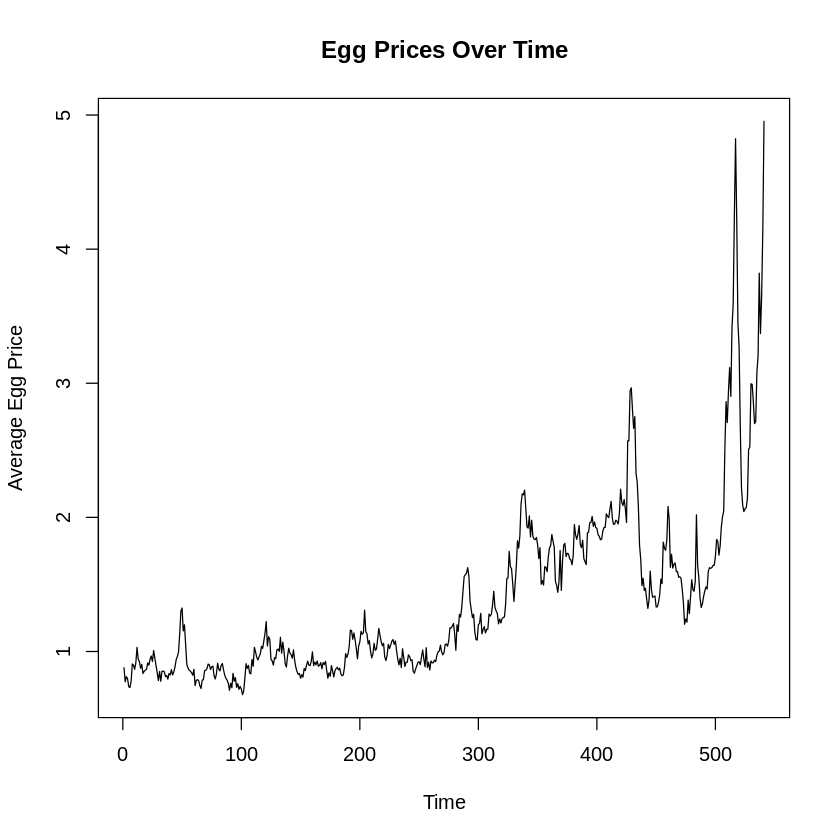

In [5]:
# create time series plot of egg prices
plot.ts(eggs$APU0000708111, main="Egg Prices Over Time",
        ylab="Average Egg Price", xlab="Time")

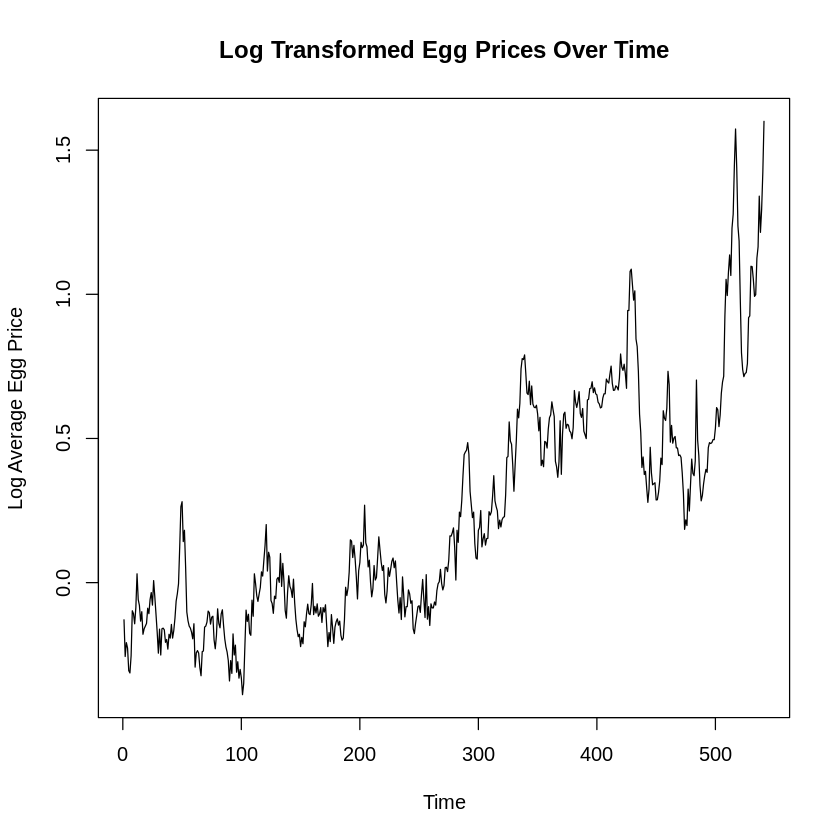

In [6]:
# nonstationary so apply log transformation
log_trans <- log(eggs$APU0000708111)

# create new time series plot
plot.ts(log_trans,
        main="Log Transformed Egg Prices Over Time",
        ylab="Log Average Egg Price",
        xlab="Time")

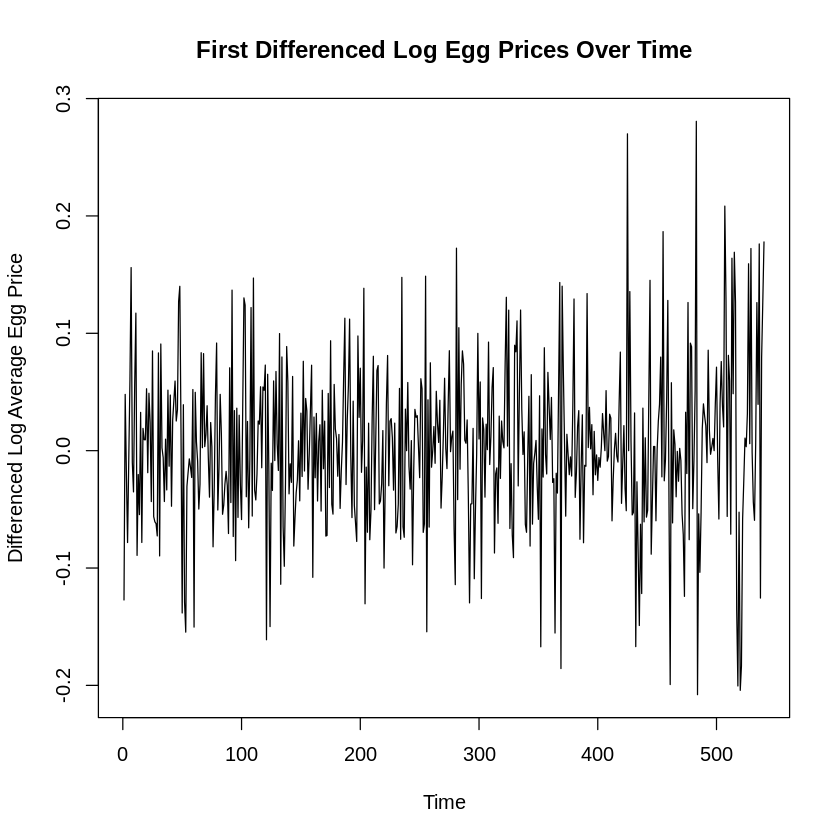

In [7]:
# Still nonstationary so apply first difference
diff_log <- diff(log_trans)

# create new time series plot
plot.ts(diff_log,
        main="First Differenced Log Egg Prices Over Time",
        ylab="Differenced Log Average Egg Price",
        xlab="Time")

In [8]:
# Use Augmented Dickey-Fuller Test for Stationarity
adf.test(diff_log, alternative = "stationary")

Warning message in adf.test(diff_log, alternative = "stationary"):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff_log
Dickey-Fuller = -8.9035, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary


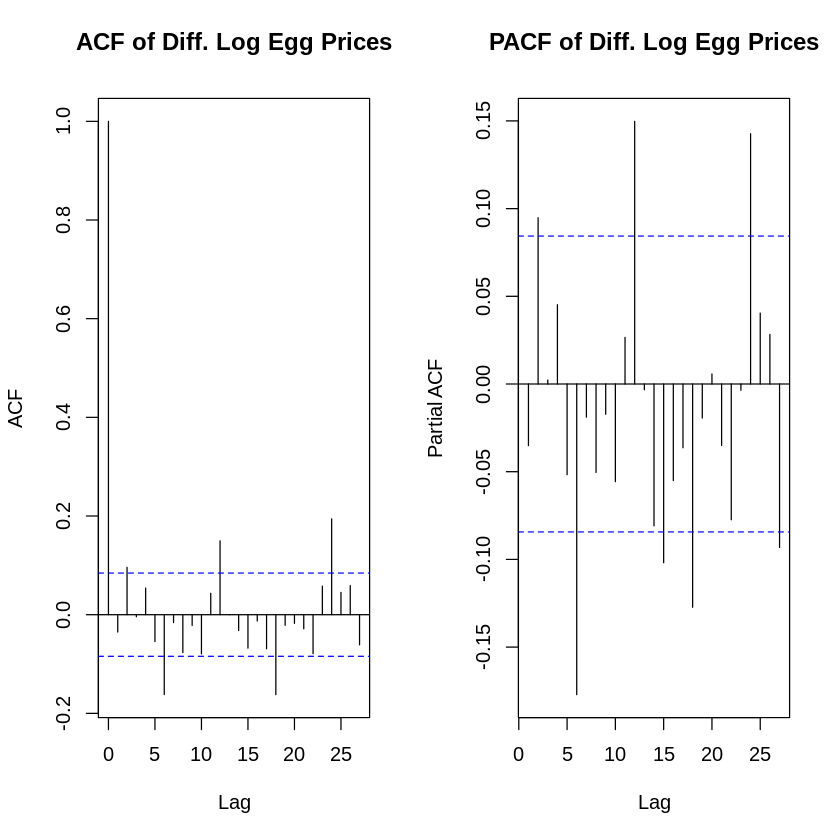

In [9]:
par(mfrow=c(1,2))  # Plot ACF and PACF side by side
acf(diff_log, main="ACF of Diff. Log Egg Prices")
pacf(diff_log, main="PACF of Diff. Log Egg Prices")
par(mfrow=c(1,1))  # Reset plot layout

## ARIMA Modeling

In [10]:
# Try possible ARIMA models
model1 <- arima(diff_log, order=c(2,0,1))  # Try ARIMA(2,1,1)
model2 <- arima(diff_log, order=c(1,0,1))  # Try ARIMA(1,1,1)
model3 <- arima(diff_log, order=c(2,0,2))  # Try ARIMA(2,1,2)

# Compare model summaries
summary(model1)
summary(model2)
summary(model3)


Call:
arima(x = diff_log, order = c(2, 0, 1))

Coefficients:
         ar1     ar2      ma1  intercept
      0.0265  0.0987  -0.0590     0.0032
s.e.  0.7638  0.0498   0.7695     0.0032

sigma^2 estimated as 0.004824:  log likelihood = 673.96,  aic = -1337.92

Training set error measures:
                      ME     RMSE        MAE MPE MAPE      MASE         ACF1
Training set 1.72135e-05 0.069458 0.05240078 NaN  Inf 0.6880035 0.0006594526


Call:
arima(x = diff_log, order = c(1, 0, 1))

Coefficients:
          ar1     ma1  intercept
      -0.6306  0.5712     0.0032
s.e.   0.1999  0.2091     0.0029

sigma^2 estimated as 0.004847:  log likelihood = 672.68,  aic = -1337.36

Training set error measures:
                        ME       RMSE        MAE MPE MAPE      MASE       ACF1
Training set -3.657314e-06 0.06962395 0.05244751 NaN  Inf 0.6886171 0.02971851


Call:
arima(x = diff_log, order = c(2, 0, 2))

Coefficients:
          ar1     ar2     ma1      ma2  intercept
      -0.0563  0.1997  0.0257  -0.1033     0.0032
s.e.   0.3687  0.2011  0.3735   0.2020     0.0032

sigma^2 estimated as 0.004822:  log likelihood = 674.07,  aic = -1336.15

Training set error measures:
                       ME       RMSE        MAE MPE MAPE      MASE
Training set 7.523459e-06 0.06944339 0.05234351 NaN  Inf 0.6872515
                      ACF1
Training set -0.0004433697

In [11]:
# create ARIMA model with best orders using automated process
best_model <- auto.arima(diff_log)
summary(best_model)

Series: diff_log 
ARIMA(2,0,0) with zero mean 

Coefficients:
          ar1     ar2
      -0.0296  0.0985
s.e.   0.0432  0.0433

sigma^2 = 0.004852:  log likelihood = 673.44
AIC=-1340.88   AICc=-1340.84   BIC=-1328.01

Training set error measures:
                      ME       RMSE        MAE MPE MAPE      MASE         ACF1
Training set 0.003027358 0.06952485 0.05242044 NaN  Inf 0.6882615 -0.001951799

## Hypothesis Testing and Evaluating Model

In [12]:
# Box-Ljung Test for Residuals
Box.test(best_model$residuals, lag=1, type = "Ljung")


	Box-Ljung test

data:  best_model$residuals
X-squared = 0.0020686, df = 1, p-value = 0.9637


[1] "RMSE: 0.112438411905539"
[1] "MAE: 0.0955568652836273"


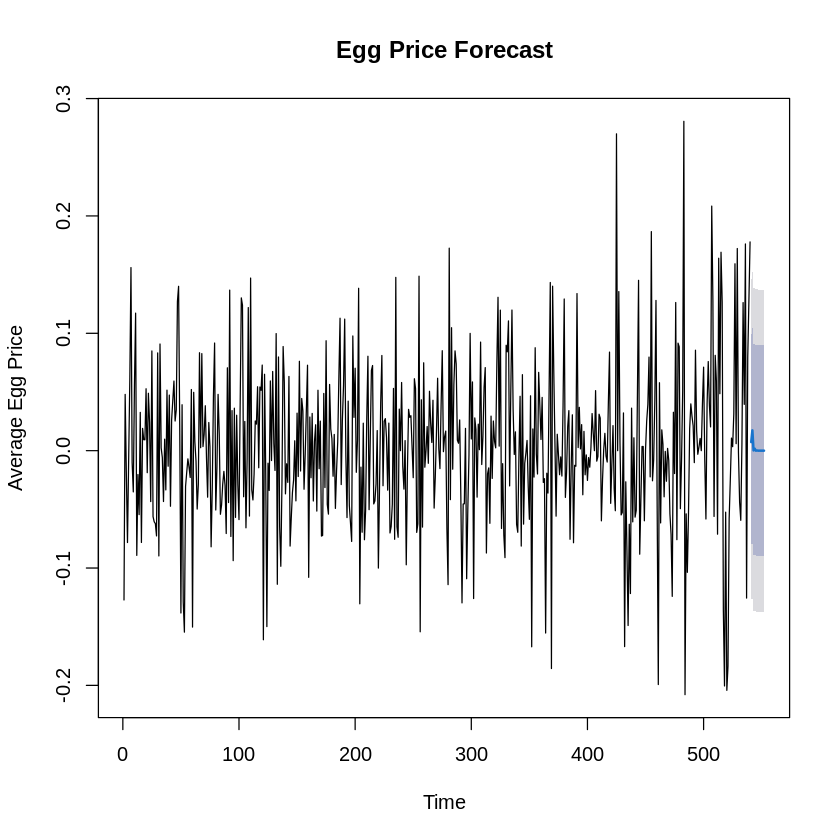

In [15]:
# Forecast the next 12 time periods (months)
forecast_values <- forecast(best_model, h=12)

# Plot the forecast
plot(forecast_values, main="Egg Price Forecast", ylab="Average Egg Price", xlab="Time")

# Calculate RMSE and MAE
actual_values <- tail(diff_log, 12)  # Last 12 actual values
predicted_values <- forecast_values$mean

rmse <- sqrt(mean((actual_values - predicted_values)^2))
mae <- mean(abs(actual_values - predicted_values))

print(paste("RMSE:", rmse))
print(paste("MAE:", mae))